In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [ ]:
def Complex_Normalize(z):
    re = z.real
    im = z.imag
    re = F.normalize(re)
    im = F.normalize(im)
    
    return torch.complex(re, im)

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
    #torch.fft.fft2,
    #torch.fft.fftshift,
    #Complex_Normalize
])

valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
    #torch.fft.fft2,
    #torch.fft.fftshift,
    #Complex_Normalize
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
    #torch.fft.fft2,
    #torch.fft.fftshift,
    #Complex_Normalize
])


# Create training set (with no transformations)
raw_data = datasets.MNIST(root="data", train=True, download=True, transform=None)

# Split the training data into pure training data and validation data (80/20 split)
train_size = int(len(raw_data) * 0.6) # 60% training data
valid_size = int(len(raw_data) * 0.2) # 20% validation data
test_size = len(raw_data)-(train_size+valid_size)

training_data, validation_data, testing_data = torch.utils.data.random_split(raw_data, [train_size, valid_size, test_size])

# Apply the respective transformations to each dataset
training_data.dataset.transform = train_transforms
validation_data.dataset.transform = valid_transforms
testing_data.dataset.transform = test_transforms

# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=32)
test_loader = DataLoader(testing_data, batch_size=32)

In [ ]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
this_batch = next(iter(train_loader))


x = np.linspace(-50, 50, 100)
y = np.linspace(-50, 50, 100)
#X, Y = np.meshgrid(x, y)
f_xy = np.heaviside(x-2,1)*np.heaviside(-x+10,1)*np.exp(-y**2/500)

f = torch.Tensor(f_xy)


def show_image_and_fft(image):
    fft = torch.fft.fft2(image)
    fft = torch.fft.fftshift(fft)
    image = image.numpy()
    fft = fft.numpy()
    fft_real = fft.real
    fft_imag = fft.imag
    fft_abs = np.abs(fft)

    #show the imaginary part of the image
    plt.imshow(image.T.squeeze().T)
    plt.show()

    plt.imshow(fft_real.T.squeeze().T)
    plt.show()
    
    plt.imshow(fft_imag.T.squeeze().T)
    plt.show()
    
    plt.imshow(fft_abs.T.squeeze().T)
    plt.show()

def show(batch, n=1):
    labels = batch[1][0:n]
    images = batch[0][0:n]
    #show inverse images and ffts
    for i in range(n):
        print(int(labels[i].detach()))
        
        inverted_image = torch.fft.fftshift(images[i])
        inverted_image = torch.fft.ifft2(images[i]).abs().numpy()

        image = transforms.functional.rotate(images[i], 90)
        image = image.abs().numpy()
        
        #show the imaginary part of the image
        plt.imshow(inverted_image.T.squeeze().T)
        plt.show()
        
        plt.imshow(image.T.squeeze().T)
        plt.show()
        
# Explore data
show_image_and_fft(f)

In [ ]:
def Haar(x,n,k):
    w = 2**(-n) * x - k
    z = torch.zeros_like(x)

    for i in range(len(x)):
        if 0 <= w[i] and w[i] < .5:
            z[i] = 2**(-n/2)
        elif .5 <= w[i] and w[i] < 1:
            z[i] = -2**(-n/2)
    
    return z

In [ ]:
n1 = 5
n2 = 5
n3 = 5

k1 = 1
k2 = 2
k3 = 3


N = 256
x = torch.arange(0, N, N/1000)

y1 = Haar(x,n1,k1)
y2 = Haar(x,n2,k2)
y3 = Haar(x,n3,k3)

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

In [ ]:
1+2**0+2**1+2**2+2**3+2**4+2**5+2**6+2**7

In [17]:
m = 28  #Dimension of target tensor
n = 32 #Dimensions of input

#Define the identity tensor and the squared distance tensor
Id = torch.zeros(m,m,n,n)
sq_dist = torch.zeros_like(Id)
Ii = torch.eye(m, n)
Jj = torch.eye(m, n)

with torch.no_grad():
    for i in range(n):
        for j in range(n):
            for I in range(m):
                for J in range(m):
                    #First create Identity tensor
                    Id[I,J,i,j] = Ii[I,i]*Jj[J,j]

                    #Now define square distance tensor
                    sq_dist[I,J,i,j] = (I/m-i/n)**2+(J/m-j/n)**2

tensor(0.0001)
tensor(0.9994)
tensor(1.0008)
tensor(1.)


<Figure size 640x480 with 0 Axes>

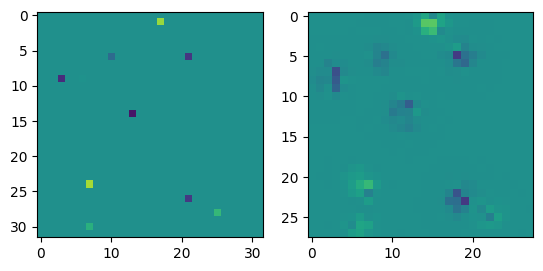

In [19]:
import random
noise_std = 1  #Standard dev of the noise
sigma = 1

gaussian = 1/(sigma*np.sqrt(2*torch.pi))*torch.exp(-m**2*sq_dist/(2*sigma**2))

U = torch.zeros(n,n)

dM = torch.randn(m, m, n, n)
print(dM.mean())
print(dM.std())
dM = (dM+1)/dM.std()*noise_std
print(dM.mean())
print(dM.std())

dM = dM*gaussian

M=dM

# Coordinates of points
points = ()
for i in range(10):
    P = (random.randint(0, n-1),random.randint(0, n-1))
    U[n-P[1]-1,P[0]]=random.randrange(-100,100)           

V = torch.tensordot(M, U, [[2,3], [0,1]])

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(U, vmin=-100, vmax=100)
axarr[1].imshow(V, vmin=-100, vmax=100)

In [15]:
A = torch.randint(low=0, high=10, size=[3, 2, 2])
print(A)

B = torch.ones([2,2], dtype=torch.int64)
print(B)

A.to(torch.float32)
B.to(torch.float32)

print(torch.tensordot(B, A, dims=([-2,-1], [-2, -1] )))

tensor([[[8, 5],
         [5, 7]],

        [[0, 0],
         [5, 0]],

        [[1, 6],
         [5, 0]]])
tensor([[1, 1],
        [1, 1]])
tensor([25,  5, 12])
